##Загрузка данных

In [ ]:
!pip install catboost

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/"
train_data_path = data_dir + "train_data.pqt"
test_data_path = data_dir + "test_data.pqt"

In [6]:
df = pd.read_parquet(train_data_path)

In [7]:
df.shape

(600000, 93)

In [8]:
df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}


## Some Eda

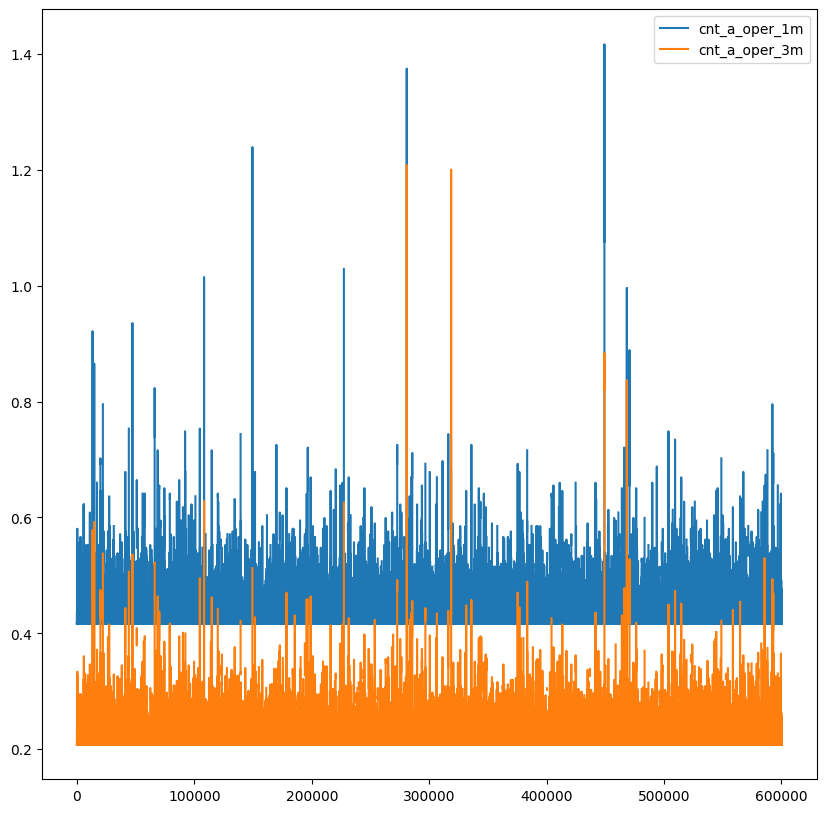

In [11]:
df[['cnt_a_oper_1m', 'cnt_a_oper_3m']].plot(figsize=(10, 10))
plt.show()

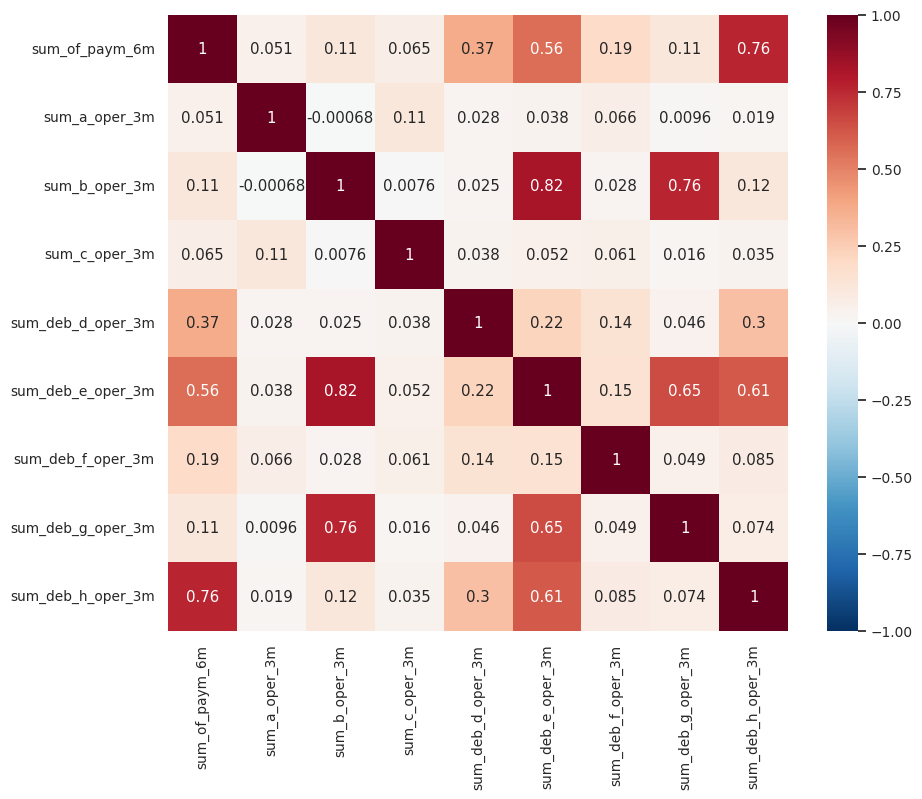

In [19]:
sns.set(font_scale=0.9)
plt.figure(figsize=(10, 8))
train_columns = df[['sum_of_paym_6m', 'sum_a_oper_3m', 'sum_b_oper_3m', 'sum_c_oper_3m','sum_deb_d_oper_3m', 'sum_deb_e_oper_3m', 'sum_deb_f_oper_3m', 'sum_deb_g_oper_3m', 'sum_deb_h_oper_3m']]
sns.heatmap(train_columns.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1)
plt.show()

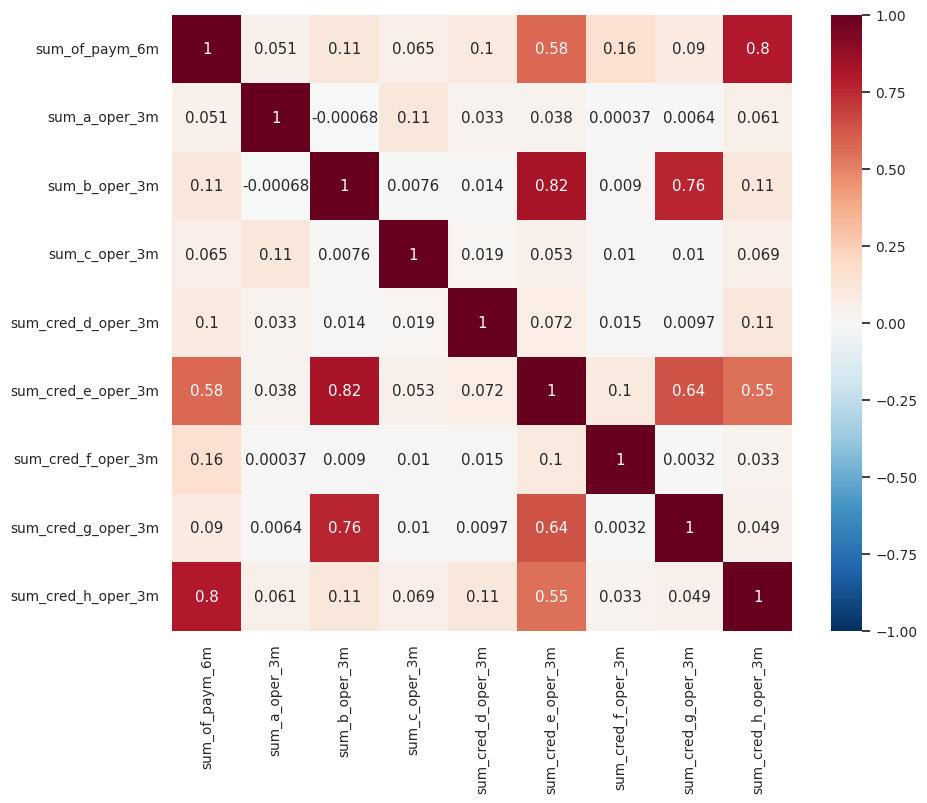

In [20]:
sns.set(font_scale=0.9)
plt.figure(figsize=(10, 8))
train_columns = df[['sum_of_paym_6m', 'sum_a_oper_3m', 'sum_b_oper_3m', 'sum_c_oper_3m','sum_cred_d_oper_3m', 'sum_cred_e_oper_3m', 'sum_cred_f_oper_3m', 'sum_cred_g_oper_3m', 'sum_cred_h_oper_3m']]
sns.heatmap(train_columns.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1)
plt.show()

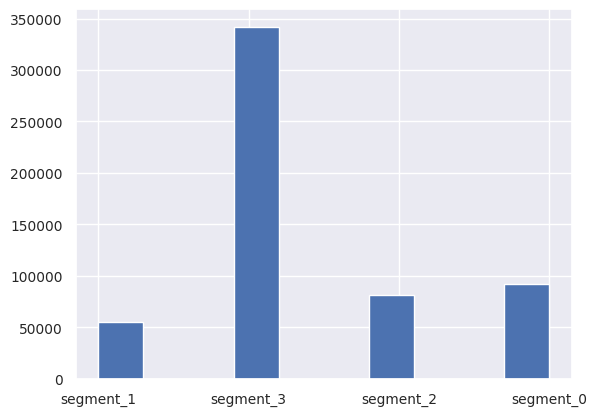

In [25]:
df['segment'].hist()
plt.show()

## Fill NaN

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

In [ ]:
df[df.select_dtypes(include="object").columns] = df.select_dtypes(include="object").fillna("")
df[df.select_dtypes(include=["float64", "int64"]).columns] = df.select_dtypes(include=["float64", "int64"]).fillna(np.nan)

## Merge 3 month in one row


In [ ]:
def merge_rows(df: pd.DataFrame) -> pd.DataFrame:
  cols = df.columns
  merged_cols = []
  for col in cols[2:]:
    merged_cols += ["1m_" + col, "2m_" + col, "3m_" + col]
  merged_df = pd.DataFrame(columns=merged_cols)
  for i, month in [("1m_", "month_1"), ("2m_", "month_2"), ("3m_", "month_3")]:
    for col in cols[2:]:
      merged_df[i + col] = df[df["date"] == month][col].values
  merged_df = merged_df.reset_index().drop(["index"], axis=1)
  return merged_df

In [ ]:
merged_df = merge_rows(df)

In [ ]:
print(merged_df.shape)
merged_df.tail()

(200000, 273)


,1m_balance_amt_avg,2m_balance_amt_avg,3m_balance_amt_avg,1m_balance_amt_max,2m_balance_amt_max,3m_balance_amt_max,1m_balance_amt_min,2m_balance_amt_min,3m_balance_amt_min,1m_balance_amt_day_avg,2m_balance_amt_day_avg,3m_balance_amt_day_avg,1m_channel_code,2m_channel_code,3m_channel_code,1m_city,2m_city,3m_city,1m_city_type,2m_city_type,3m_city_type,1m_index_city_code,2m_index_city_code,3m_index_city_code,1m_ogrn_days_end_month,2m_ogrn_days_end_month,3m_ogrn_days_end_month,1m_ogrn_days_end_quarter,2m_ogrn_days_end_quarter,3m_ogrn_days_end_quarter,1m_ogrn_month,2m_ogrn_month,3m_ogrn_month,1m_ogrn_year,2m_ogrn_year,3m_ogrn_year,1m_ft_registration_date,2m_ft_registration_date,3m_ft_registration_date,1m_max_founderpres,2m_max_founderpres,3m_max_founderpres,1m_min_founderpres,2m_min_founderpres,3m_min_founderpres,1m_ogrn_exist_months,2m_ogrn_exist_months,3m_ogrn_exist_months,1m_okved,2m_okved,3m_okved,1m_segment,2m_segment,3m_segment,1m_sum_of_paym_2m,2m_sum_of_paym_2m,3m_sum_of_paym_2m,1m_sum_of_paym_6m,2m_sum_of_paym_6m,3m_sum_of_paym_6m,1m_sum_of_paym_1y,2m_sum_of_paym_1y,3m_sum_of_paym_1y,1m_sum_a_oper_1m,2m_sum_a_oper_1m,3m_sum_a_oper_1m,1m_cnt_a_oper_1m,2m_cnt_a_oper_1m,3m_cnt_a_oper_1m,1m_sum_b_oper_1m,2m_sum_b_oper_1m,3m_sum_b_oper_1m,1m_cnt_b_oper_1m,2m_cnt_b_oper_1m,3m_cnt_b_oper_1m,1m_sum_c_oper_1m,2m_sum_c_oper_1m,3m_sum_c_oper_1m,1m_cnt_c_oper_1m,2m_cnt_c_oper_1m,3m_cnt_c_oper_1m,1m_sum_deb_d_oper_1m,2m_sum_deb_d_oper_1m,3m_sum_deb_d_oper_1m,1m_cnt_deb_d_oper_1m,2m_cnt_deb_d_oper_1m,3m_cnt_deb_d_oper_1m,1m_sum_cred_d_oper_1m,2m_sum_cred_d_oper_1m,3m_sum_cred_d_oper_1m,1m_cnt_cred_d_oper_1m,2m_cnt_cred_d_oper_1m,3m_cnt_cred_d_oper_1m,1m_sum_deb_e_oper_1m,2m_sum_deb_e_oper_1m,3m_sum_deb_e_oper_1m,1m_cnt_deb_e_oper_1m,2m_cnt_deb_e_oper_1m,3m_cnt_deb_e_oper_1m,1m_cnt_days_deb_e_oper_1m,2m_cnt_days_deb_e_oper_1m,3m_cnt_days_deb_e_oper_1m,1m_sum_cred_e_oper_1m,2m_sum_cred_e_oper_1m,3m_sum_cred_e_oper_1m,1m_cnt_cred_e_oper_1m,2m_cnt_cred_e_oper_1m,3m_cnt_cred_e_oper_1m,1m_cnt_days_cred_e_oper_1m,2m_cnt_days_cred_e_oper_1m,3m_cnt_days_cred_e_oper_1m,1m_sum_deb_f_oper_1m,2m_sum_deb_f_oper_1m,3m_sum_deb_f_oper_1m,1m_cnt_deb_f_oper_1m,2m_cnt_deb_f_oper_1m,3m_cnt_deb_f_oper_1m,1m_cnt_days_deb_f_oper_1m,2m_cnt_days_deb_f_oper_1m,3m_cnt_days_deb_f_oper_1m,1m_sum_cred_f_oper_1m,2m_sum_cred_f_oper_1m,3m_sum_cred_f_oper_1m,1m_cnt_cred_f_oper_1m,2m_cnt_cred_f_oper_1m,3m_cnt_cred_f_oper_1m,1m_cnt_days_cred_f_oper_1m,2m_cnt_days_cred_f_oper_1m,3m_cnt_days_cred_f_oper_1m,1m_sum_deb_g_oper_1m,2m_sum_deb_g_oper_1m,3m_sum_deb_g_oper_1m,1m_cnt_deb_g_oper_1m,2m_cnt_deb_g_oper_1m,3m_cnt_deb_g_oper_1m,1m_cnt_days_deb_g_oper_1m,2m_cnt_days_deb_g_oper_1m,3m_cnt_days_deb_g_oper_1m,1m_sum_cred_g_oper_1m,2m_sum_cred_g_oper_1m,3m_sum_cred_g_oper_1m,1m_cnt_cred_g_oper_1m,2m_cnt_cred_g_oper_1m,3m_cnt_cred_g_oper_1m,1m_cnt_days_cred_g_oper_1m,2m_cnt_days_cred_g_oper_1m,3m_cnt_days_cred_g_oper_1m,1m_sum_deb_h_oper_1m,2m_sum_deb_h_oper_1m,3m_sum_deb_h_oper_1m,1m_cnt_deb_h_oper_1m,2m_cnt_deb_h_oper_1m,3m_cnt_deb_h_oper_1m,1m_cnt_days_deb_h_oper_1m,2m_cnt_days_deb_h_oper_1m,3m_cnt_days_deb_h_oper_1m,1m_sum_cred_h_oper_1m,2m_sum_cred_h_oper_1m,3m_sum_cred_h_oper_1m,1m_cnt_cred_h_oper_1m,2m_cnt_cred_h_oper_1m,3m_cnt_cred_h_oper_1m,1m_cnt_days_cred_h_oper_1m,2m_cnt_days_cred_h_oper_1m,3m_cnt_days_cred_h_oper_1m,1m_sum_a_oper_3m,2m_sum_a_oper_3m,3m_sum_a_oper_3m,1m_cnt_a_oper_3m,2m_cnt_a_oper_3m,3m_cnt_a_oper_3m,1m_sum_b_oper_3m,2m_sum_b_oper_3m,3m_sum_b_oper_3m,1m_cnt_b_oper_3m,2m_cnt_b_oper_3m,3m_cnt_b_oper_3m,1m_sum_c_oper_3m,2m_sum_c_oper_3m,3m_sum_c_oper_3m,1m_cnt_c_oper_3m,2m_cnt_c_oper_3m,3m_cnt_c_oper_3m,1m_sum_deb_d_oper_3m,2m_sum_deb_d_oper_3m,3m_sum_deb_d_oper_3m,1m_cnt_deb_d_oper_3m,2m_cnt_deb_d_oper_3m,3m_cnt_deb_d_oper_3m,1m_sum_cred_d_oper_3m,2m_sum_cred_d_oper_3m,3m_sum_cred_d_oper_3m,1m_cnt_cred_d_oper_3m,2m_cnt_cred_d_oper_3m,3m_cnt_cred_d_oper_3m,1m_sum_deb_e_oper_3m,2m_sum_deb_e_oper_3m,3m_sum_deb_e_oper_3m,1m_cnt_deb_e_oper_3m,2m_cnt_deb_e_op

In [ ]:
merged_df[["1m_start_cluster", "2m_start_cluster", "3m_start_cluster"]].value_counts()

1m_start_cluster  2m_start_cluster  3m_start_cluster
{α}               {α}               {α}                 109043
{α, η}            {α, η}            {α, η}               12232
{}                {}                {α}                  11919
                                    {}                   11886
{α, γ}            {α, γ}            {α, γ}                9067
{other}           {other}           {other}               8602
{}                {α}               {α}                   7711
{α}               {α}               {}                    2546
{α, β}            {α, β}            {α, β}                2435
{α}               {}                {}                    2059
{α, δ}            {α, δ}            {α, δ}                2052
{α, ε}            {α, ε}            {α, ε}                1508
{α, θ}            {α, θ}            {α, θ}                1306
{α}               {α, η}            {α, η}                 862
{α, ψ}            {α, ψ}            {α, ψ}                 832
{}

In [ ]:
merged_df.columns

Index(['1m_balance_amt_avg', '2m_balance_amt_avg', '3m_balance_amt_avg',
       '1m_balance_amt_max', '2m_balance_amt_max', '3m_balance_amt_max',
       '1m_balance_amt_min', '2m_balance_amt_min', '3m_balance_amt_min',
       '1m_balance_amt_day_avg',
       ...
       '3m_cnt_cred_h_oper_3m', '1m_cnt_days_cred_h_oper_3m',
       '2m_cnt_days_cred_h_oper_3m', '3m_cnt_days_cred_h_oper_3m',
       '1m_start_cluster', '2m_start_cluster', '3m_start_cluster',
       '1m_end_cluster', '2m_end_cluster', '3m_end_cluster'],
      dtype='object', length=273)

## Drop unnessusary columns

In [ ]:
# Are equal for all 3 months
drop_cols = [
    "index_city_code",
    "end_cluster"
]

In [ ]:
for col in drop_cols:
  merged_df = merged_df.drop(["1m_" + col, "2m_" + col, "3m_" + col], axis=1)

## Model to predict start of third month

In [ ]:
X = merged_df.drop("3m_start_cluster", axis=1)
y = merged_df["3m_start_cluster"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160000, 266) (40000, 266) (160000,) (40000,)


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
merged_cat_cols = [
    "1m_channel_code", "2m_channel_code", "3m_channel_code",
    "1m_city", "2m_city","3m_city",
    "1m_city_type", "2m_city_type", "3m_city_type",
    "1m_okved", "2m_okved", "3m_okved",
    "1m_segment", "2m_segment", "3m_segment",
    "1m_start_cluster", "2m_start_cluster",
    "1m_ogrn_month", "2m_ogrn_month", "3m_ogrn_month",
    "1m_ogrn_year", "2m_ogrn_year", "3m_ogrn_year",
]

In [ ]:
model = CatBoostClassifier(task_type="GPU", devices="0", random_seed=42).fit(X_train, y_train, cat_features=merged_cat_cols)

In [ ]:
pred = model.predict_proba(X_test)
print(pred.shape)
print(pred[0])

(40000, 17)
[3.00865673e-04 2.48051636e-05 1.70272541e-03 5.92625695e-03
 1.60517841e-02 3.21709690e-07 2.15646292e-06 1.31322475e-06
 2.04125763e-04 1.21897438e-03 6.45979092e-04 3.79920956e-04
 3.21118762e-05 5.22690334e-07 4.46470035e-05 9.73463083e-01
 4.06185703e-07]


In [ ]:
roc_auc_score(y_test, pred, labels=model.classes_, multi_class="ovr")

0.9913924224599959

## Make same work with test data

In [ ]:
test = pd.read_parquet(data_dir + 'test_data.pqt')
test.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,okved,segment,sum_of_paym_2m,sum_of_paym_6m,sum_of_paym_1y,sum_a_oper_1m,cnt_a_oper_1m,sum_b_oper_1m,cnt_b_oper_1m,sum_c_oper_1m,cnt_c_oper_1m,sum_deb_d_oper_1m,cnt_deb_d_oper_1m,sum_cred_d_oper_1m,cnt_cred_d_oper_1m,sum_deb_e_oper_1m,cnt_deb_e_oper_1m,cnt_days_deb_e_oper_1m,sum_cred_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,sum_deb_f_oper_1m,cnt_deb_f_oper_1m,cnt_days_deb_f_oper_1m,sum_cred_f_oper_1m,cnt_cred_f_oper_1m,cnt_days_cred_f_oper_1m,sum_deb_g_oper_1m,cnt_deb_g_oper_1m,cnt_days_deb_g_oper_1m,sum_cred_g_oper_1m,cnt_cred_g_oper_1m,cnt_days_cred_g_oper_1m,sum_deb_h_oper_1m,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,sum_a_oper_3m,cnt_a_oper_3m,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,cnt_cred_f_oper_3m,cnt_days_cred_f_oper_3m,sum_deb_g_oper_3m,cnt_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.653810,NaN,NaN,-0.658497,okved_0,segment_3,0.416833,0.332409,0.676573,0.532156,0.421695,-0.030225,0.435995,1.123507,0.552726,-0.128513,0.96703,-0.063678,0.221993,0.278159,0.893289,0.818244,0.266375,0.873550,0.526503,4.591710,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.034588,0.515230,0.913334,0.078352,0.226247,0.326923,-0.144097,0.652523,0.291082,0.413722,0.605505,0.500338,0.957934,0.214730,-0.029964,0.517298,1.660281,0.963300,-0.143207,0.870124,-0.055135,0.309193,0.175471,0.426448,1.366376,0.143413,0.863866,0.951836,3.136945,0.286081,0.902845,-0.025646,0.24851,0.038562,0.026364,0.460730,0.849386,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.636647,NaN,NaN,-0.641101,okved_0,segment_3,0.433195,0.284317,0.688449,-0.069498,0.421695,-0.030225,0.435995,4.983369,0.556064,-0.128513,0.96703,0.089395,0.223973,0.119735,0.893536,0.850502,0.131938,0.873598,0.526503,1.399146,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.010645,0.514586,0.881076,-0.029795,0.223291,0.294665,-0.145537,0.652216,0.194308,0.363179,0.612262,0.532596,1.002756,0.216298,-0.029964,0.517298,3.022775,0.963687,-0.143207,0.870124,-0.008083,0.309193,0.195415,0.426482,1.410332,0.189248,0.863929,1.061726,3.136964,0.286088,0.913834,-0.025646,0.24851,0.038562,0.003038,0.459615,0.805430,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,ogrn_month_8,ogrn_year_11,-0.618911,NaN,NaN,-0.623705,okved_0,segment_3,0.223961,0.285376,0.671862,2.698111,0.431041,-0.030225,0.435995,4.186482,0.557473,-0.128513,0.96703,-0.063678,0.221993,-0.002000,0.893674,0.753728,0.090933,0.873559,0.526503,-0.173564,0.771321,0.180270,-0.017983,0.154163,0.777702,0.000068,0.515230,0.913334,-0.029795,0.223291,0.294665,-0.150212,0.651909,0.194308,0.219106,0.605505,0.468080,1.182043,0.216298,-0.029964,0.517298,4.162265,0.965149,-0.143207,0.870124,-0.014715,0.308564,0.149694,0.426615,1.465277,0.185240,0.863974,1.171616,2.470867,0.286081,0.902845,-0.

In [ ]:
test[test.select_dtypes(include="object").columns] = test.select_dtypes(include="object").fillna("")
test[test.select_dtypes(include=["float64", "int64"]).columns] = test.select_dtypes(include=["float64", "int64"]).fillna(np.nan)

## Return months

In [ ]:
def implace_months(df: pd.DataFrame) -> pd.DataFrame:
  from itertools import product
  target_df = pd.DataFrame(list(product(test["id"].unique(), ["month_4", "month_5", "month_6"])), columns=['id', 'date'])
  result_df = pd.merge(target_df, df, on=["id", "date"], how="left")
  result_df[result_df.select_dtypes(include="object").columns] = result_df.select_dtypes(include="object").fillna("")
  result_df[result_df.select_dtypes(include=["float64", "int64"]).columns] = result_df.select_dtypes(include=["float64", "int64"]).fillna(np.nan)
  return result_df.sort_values(["id", "date"])

In [ ]:
test = implace_months(test)

In [ ]:
def transform_month(month: str) -> str:
  if month == "month_4":
    return "month_1"
  if month == "month_5":
    return "month_2"
  if month == "month_6":
    return "month_3"
  return month

In [ ]:
test["date"] = test["date"].apply(transform_month)
test["date"].value_counts()

month_1    100000
month_2    100000
month_3    100000
Name: date, dtype: int64

In [ ]:
merged_test = merge_rows(test)

In [ ]:
drop_cols = [
    "1m_index_city_code", "2m_index_city_code", "3m_index_city_code",
]
merged_test.drop(drop_cols, axis=1, inplace=True)

In [ ]:
merged_test.tail()

,1m_balance_amt_avg,2m_balance_amt_avg,3m_balance_amt_avg,1m_balance_amt_max,2m_balance_amt_max,3m_balance_amt_max,1m_balance_amt_min,2m_balance_amt_min,3m_balance_amt_min,1m_balance_amt_day_avg,2m_balance_amt_day_avg,3m_balance_amt_day_avg,1m_channel_code,2m_channel_code,3m_channel_code,1m_city,2m_city,3m_city,1m_city_type,2m_city_type,3m_city_type,1m_ogrn_days_end_month,2m_ogrn_days_end_month,3m_ogrn_days_end_month,1m_ogrn_days_end_quarter,2m_ogrn_days_end_quarter,3m_ogrn_days_end_quarter,1m_ogrn_month,2m_ogrn_month,3m_ogrn_month,1m_ogrn_year,2m_ogrn_year,3m_ogrn_year,1m_ft_registration_date,2m_ft_registration_date,3m_ft_registration_date,1m_max_founderpres,2m_max_founderpres,3m_max_founderpres,1m_min_founderpres,2m_min_founderpres,3m_min_founderpres,1m_ogrn_exist_months,2m_ogrn_exist_months,3m_ogrn_exist_months,1m_okved,2m_okved,3m_okved,1m_segment,2m_segment,3m_segment,1m_sum_of_paym_2m,2m_sum_of_paym_2m,3m_sum_of_paym_2m,1m_sum_of_paym_6m,2m_sum_of_paym_6m,3m_sum_of_paym_6m,1m_sum_of_paym_1y,2m_sum_of_paym_1y,3m_sum_of_paym_1y,1m_sum_a_oper_1m,2m_sum_a_oper_1m,3m_sum_a_oper_1m,1m_cnt_a_oper_1m,2m_cnt_a_oper_1m,3m_cnt_a_oper_1m,1m_sum_b_oper_1m,2m_sum_b_oper_1m,3m_sum_b_oper_1m,1m_cnt_b_oper_1m,2m_cnt_b_oper_1m,3m_cnt_b_oper_1m,1m_sum_c_oper_1m,2m_sum_c_oper_1m,3m_sum_c_oper_1m,1m_cnt_c_oper_1m,2m_cnt_c_oper_1m,3m_cnt_c_oper_1m,1m_sum_deb_d_oper_1m,2m_sum_deb_d_oper_1m,3m_sum_deb_d_oper_1m,1m_cnt_deb_d_oper_1m,2m_cnt_deb_d_oper_1m,3m_cnt_deb_d_oper_1m,1m_sum_cred_d_oper_1m,2m_sum_cred_d_oper_1m,3m_sum_cred_d_oper_1m,1m_cnt_cred_d_oper_1m,2m_cnt_cred_d_oper_1m,3m_cnt_cred_d_oper_1m,1m_sum_deb_e_oper_1m,2m_sum_deb_e_oper_1m,3m_sum_deb_e_oper_1m,1m_cnt_deb_e_oper_1m,2m_cnt_deb_e_oper_1m,3m_cnt_deb_e_oper_1m,1m_cnt_days_deb_e_oper_1m,2m_cnt_days_deb_e_oper_1m,3m_cnt_days_deb_e_oper_1m,1m_sum_cred_e_oper_1m,2m_sum_cred_e_oper_1m,3m_sum_cred_e_oper_1m,1m_cnt_cred_e_oper_1m,2m_cnt_cred_e_oper_1m,3m_cnt_cred_e_oper_1m,1m_cnt_days_cred_e_oper_1m,2m_cnt_days_cred_e_oper_1m,3m_cnt_days_cred_e_oper_1m,1m_sum_deb_f_oper_1m,2m_sum_deb_f_oper_1m,3m_sum_deb_f_oper_1m,1m_cnt_deb_f_oper_1m,2m_cnt_deb_f_oper_1m,3m_cnt_deb_f_oper_1m,1m_cnt_days_deb_f_oper_1m,2m_cnt_days_deb_f_oper_1m,3m_cnt_days_deb_f_oper_1m,1m_sum_cred_f_oper_1m,2m_sum_cred_f_oper_1m,3m_sum_cred_f_oper_1m,1m_cnt_cred_f_oper_1m,2m_cnt_cred_f_oper_1m,3m_cnt_cred_f_oper_1m,1m_cnt_days_cred_f_oper_1m,2m_cnt_days_cred_f_oper_1m,3m_cnt_days_cred_f_oper_1m,1m_sum_deb_g_oper_1m,2m_sum_deb_g_oper_1m,3m_sum_deb_g_oper_1m,1m_cnt_deb_g_oper_1m,2m_cnt_deb_g_oper_1m,3m_cnt_deb_g_oper_1m,1m_cnt_days_deb_g_oper_1m,2m_cnt_days_deb_g_oper_1m,3m_cnt_days_deb_g_oper_1m,1m_sum_cred_g_oper_1m,2m_sum_cred_g_oper_1m,3m_sum_cred_g_oper_1m,1m_cnt_cred_g_oper_1m,2m_cnt_cred_g_oper_1m,3m_cnt_cred_g_oper_1m,1m_cnt_days_cred_g_oper_1m,2m_cnt_days_cred_g_oper_1m,3m_cnt_days_cred_g_oper_1m,1m_sum_deb_h_oper_1m,2m_sum_deb_h_oper_1m,3m_sum_deb_h_oper_1m,1m_cnt_deb_h_oper_1m,2m_cnt_deb_h_oper_1m,3m_cnt_deb_h_oper_1m,1m_cnt_days_deb_h_oper_1m,2m_cnt_days_deb_h_oper_1m,3m_cnt_days_deb_h_oper_1m,1m_sum_cred_h_oper_1m,2m_sum_cred_h_oper_1m,3m_sum_cred_h_oper_1m,1m_cnt_cred_h_oper_1m,2m_cnt_cred_h_oper_1m,3m_cnt_cred_h_oper_1m,1m_cnt_days_cred_h_oper_1m,2m_cnt_days_cred_h_oper_1m,3m_cnt_days_cred_h_oper_1m,1m_sum_a_oper_3m,2m_sum_a_oper_3m,3m_sum_a_oper_3m,1m_cnt_a_oper_3m,2m_cnt_a_oper_3m,3m_cnt_a_oper_3m,1m_sum_b_oper_3m,2m_sum_b_oper_3m,3m_sum_b_oper_3m,1m_cnt_b_oper_3m,2m_cnt_b_oper_3m,3m_cnt_b_oper_3m,1m_sum_c_oper_3m,2m_sum_c_oper_3m,3m_sum_c_oper_3m,1m_cnt_c_oper_3m,2m_cnt_c_oper_3m,3m_cnt_c_oper_3m,1m_sum_deb_d_oper_3m,2m_sum_deb_d_oper_3m,3m_sum_deb_d_oper_3m,1m_cnt_deb_d_oper_3m,2m_cnt_deb_d_oper_3m,3m_cnt_deb_d_oper_3m,1m_sum_cred_d_oper_3m,2m_sum_cred_d_oper_3m,3m_sum_cred_d_oper_3m,1m_cnt_cred_d_oper_3m,2m_cnt_cred_d_oper_3m,3m_cnt_cred_d_oper_3m,1m_sum_deb_e_oper_3m,2m_sum_deb_e_oper_3m,3m_sum_deb_e_oper_3m,1m_cnt_deb_e_oper_3m,2m_cnt_deb_e_oper_3m,3m_cnt_deb_e_oper_3m,1m_cnt_days_deb_e_oper_3m,2m_c

## Predict start of 3rd month in test dataset

In [ ]:
merged_test["3m_start_cluster"] = model.predict(merged_test.drop("3m_start_cluster", axis=1))

In [ ]:
merged_test.sample(10)

,1m_balance_amt_avg,2m_balance_amt_avg,3m_balance_amt_avg,1m_balance_amt_max,2m_balance_amt_max,3m_balance_amt_max,1m_balance_amt_min,2m_balance_amt_min,3m_balance_amt_min,1m_balance_amt_day_avg,2m_balance_amt_day_avg,3m_balance_amt_day_avg,1m_channel_code,2m_channel_code,3m_channel_code,1m_city,2m_city,3m_city,1m_city_type,2m_city_type,3m_city_type,1m_ogrn_days_end_month,2m_ogrn_days_end_month,3m_ogrn_days_end_month,1m_ogrn_days_end_quarter,2m_ogrn_days_end_quarter,3m_ogrn_days_end_quarter,1m_ogrn_month,2m_ogrn_month,3m_ogrn_month,1m_ogrn_year,2m_ogrn_year,3m_ogrn_year,1m_ft_registration_date,2m_ft_registration_date,3m_ft_registration_date,1m_max_founderpres,2m_max_founderpres,3m_max_founderpres,1m_min_founderpres,2m_min_founderpres,3m_min_founderpres,1m_ogrn_exist_months,2m_ogrn_exist_months,3m_ogrn_exist_months,1m_okved,2m_okved,3m_okved,1m_segment,2m_segment,3m_segment,1m_sum_of_paym_2m,2m_sum_of_paym_2m,3m_sum_of_paym_2m,1m_sum_of_paym_6m,2m_sum_of_paym_6m,3m_sum_of_paym_6m,1m_sum_of_paym_1y,2m_sum_of_paym_1y,3m_sum_of_paym_1y,1m_sum_a_oper_1m,2m_sum_a_oper_1m,3m_sum_a_oper_1m,1m_cnt_a_oper_1m,2m_cnt_a_oper_1m,3m_cnt_a_oper_1m,1m_sum_b_oper_1m,2m_sum_b_oper_1m,3m_sum_b_oper_1m,1m_cnt_b_oper_1m,2m_cnt_b_oper_1m,3m_cnt_b_oper_1m,1m_sum_c_oper_1m,2m_sum_c_oper_1m,3m_sum_c_oper_1m,1m_cnt_c_oper_1m,2m_cnt_c_oper_1m,3m_cnt_c_oper_1m,1m_sum_deb_d_oper_1m,2m_sum_deb_d_oper_1m,3m_sum_deb_d_oper_1m,1m_cnt_deb_d_oper_1m,2m_cnt_deb_d_oper_1m,3m_cnt_deb_d_oper_1m,1m_sum_cred_d_oper_1m,2m_sum_cred_d_oper_1m,3m_sum_cred_d_oper_1m,1m_cnt_cred_d_oper_1m,2m_cnt_cred_d_oper_1m,3m_cnt_cred_d_oper_1m,1m_sum_deb_e_oper_1m,2m_sum_deb_e_oper_1m,3m_sum_deb_e_oper_1m,1m_cnt_deb_e_oper_1m,2m_cnt_deb_e_oper_1m,3m_cnt_deb_e_oper_1m,1m_cnt_days_deb_e_oper_1m,2m_cnt_days_deb_e_oper_1m,3m_cnt_days_deb_e_oper_1m,1m_sum_cred_e_oper_1m,2m_sum_cred_e_oper_1m,3m_sum_cred_e_oper_1m,1m_cnt_cred_e_oper_1m,2m_cnt_cred_e_oper_1m,3m_cnt_cred_e_oper_1m,1m_cnt_days_cred_e_oper_1m,2m_cnt_days_cred_e_oper_1m,3m_cnt_days_cred_e_oper_1m,1m_sum_deb_f_oper_1m,2m_sum_deb_f_oper_1m,3m_sum_deb_f_oper_1m,1m_cnt_deb_f_oper_1m,2m_cnt_deb_f_oper_1m,3m_cnt_deb_f_oper_1m,1m_cnt_days_deb_f_oper_1m,2m_cnt_days_deb_f_oper_1m,3m_cnt_days_deb_f_oper_1m,1m_sum_cred_f_oper_1m,2m_sum_cred_f_oper_1m,3m_sum_cred_f_oper_1m,1m_cnt_cred_f_oper_1m,2m_cnt_cred_f_oper_1m,3m_cnt_cred_f_oper_1m,1m_cnt_days_cred_f_oper_1m,2m_cnt_days_cred_f_oper_1m,3m_cnt_days_cred_f_oper_1m,1m_sum_deb_g_oper_1m,2m_sum_deb_g_oper_1m,3m_sum_deb_g_oper_1m,1m_cnt_deb_g_oper_1m,2m_cnt_deb_g_oper_1m,3m_cnt_deb_g_oper_1m,1m_cnt_days_deb_g_oper_1m,2m_cnt_days_deb_g_oper_1m,3m_cnt_days_deb_g_oper_1m,1m_sum_cred_g_oper_1m,2m_sum_cred_g_oper_1m,3m_sum_cred_g_oper_1m,1m_cnt_cred_g_oper_1m,2m_cnt_cred_g_oper_1m,3m_cnt_cred_g_oper_1m,1m_cnt_days_cred_g_oper_1m,2m_cnt_days_cred_g_oper_1m,3m_cnt_days_cred_g_oper_1m,1m_sum_deb_h_oper_1m,2m_sum_deb_h_oper_1m,3m_sum_deb_h_oper_1m,1m_cnt_deb_h_oper_1m,2m_cnt_deb_h_oper_1m,3m_cnt_deb_h_oper_1m,1m_cnt_days_deb_h_oper_1m,2m_cnt_days_deb_h_oper_1m,3m_cnt_days_deb_h_oper_1m,1m_sum_cred_h_oper_1m,2m_sum_cred_h_oper_1m,3m_sum_cred_h_oper_1m,1m_cnt_cred_h_oper_1m,2m_cnt_cred_h_oper_1m,3m_cnt_cred_h_oper_1m,1m_cnt_days_cred_h_oper_1m,2m_cnt_days_cred_h_oper_1m,3m_cnt_days_cred_h_oper_1m,1m_sum_a_oper_3m,2m_sum_a_oper_3m,3m_sum_a_oper_3m,1m_cnt_a_oper_3m,2m_cnt_a_oper_3m,3m_cnt_a_oper_3m,1m_sum_b_oper_3m,2m_sum_b_oper_3m,3m_sum_b_oper_3m,1m_cnt_b_oper_3m,2m_cnt_b_oper_3m,3m_cnt_b_oper_3m,1m_sum_c_oper_3m,2m_sum_c_oper_3m,3m_sum_c_oper_3m,1m_cnt_c_oper_3m,2m_cnt_c_oper_3m,3m_cnt_c_oper_3m,1m_sum_deb_d_oper_3m,2m_sum_deb_d_oper_3m,3m_sum_deb_d_oper_3m,1m_cnt_deb_d_oper_3m,2m_cnt_deb_d_oper_3m,3m_cnt_deb_d_oper_3m,1m_sum_cred_d_oper_3m,2m_sum_cred_d_oper_3m,3m_sum_cred_d_oper_3m,1m_cnt_cred_d_oper_3m,2m_cnt_cred_d_oper_3m,3m_cnt_cred_d_oper_3m,1m_sum_deb_e_oper_3m,2m_sum_deb_e_oper_3m,3m_sum_deb_e_oper_3m,1m_cnt_deb_e_oper_3m,2m_cnt_deb_e_oper_3m,3m_cnt_deb_e_oper_3m,1m_cnt_days_deb_e_oper_3m,2m_c

# Fit model to predict end cluster of third month

In [ ]:
merged_df = merge_rows(df)
merged_df.head()

,1m_balance_amt_avg,2m_balance_amt_avg,3m_balance_amt_avg,1m_balance_amt_max,2m_balance_amt_max,3m_balance_amt_max,1m_balance_amt_min,2m_balance_amt_min,3m_balance_amt_min,1m_balance_amt_day_avg,2m_balance_amt_day_avg,3m_balance_amt_day_avg,1m_channel_code,2m_channel_code,3m_channel_code,1m_city,2m_city,3m_city,1m_city_type,2m_city_type,3m_city_type,1m_index_city_code,2m_index_city_code,3m_index_city_code,1m_ogrn_days_end_month,2m_ogrn_days_end_month,3m_ogrn_days_end_month,1m_ogrn_days_end_quarter,2m_ogrn_days_end_quarter,3m_ogrn_days_end_quarter,1m_ogrn_month,2m_ogrn_month,3m_ogrn_month,1m_ogrn_year,2m_ogrn_year,3m_ogrn_year,1m_ft_registration_date,2m_ft_registration_date,3m_ft_registration_date,1m_max_founderpres,2m_max_founderpres,3m_max_founderpres,1m_min_founderpres,2m_min_founderpres,3m_min_founderpres,1m_ogrn_exist_months,2m_ogrn_exist_months,3m_ogrn_exist_months,1m_okved,2m_okved,3m_okved,1m_segment,2m_segment,3m_segment,1m_sum_of_paym_2m,2m_sum_of_paym_2m,3m_sum_of_paym_2m,1m_sum_of_paym_6m,2m_sum_of_paym_6m,3m_sum_of_paym_6m,1m_sum_of_paym_1y,2m_sum_of_paym_1y,3m_sum_of_paym_1y,1m_sum_a_oper_1m,2m_sum_a_oper_1m,3m_sum_a_oper_1m,1m_cnt_a_oper_1m,2m_cnt_a_oper_1m,3m_cnt_a_oper_1m,1m_sum_b_oper_1m,2m_sum_b_oper_1m,3m_sum_b_oper_1m,1m_cnt_b_oper_1m,2m_cnt_b_oper_1m,3m_cnt_b_oper_1m,1m_sum_c_oper_1m,2m_sum_c_oper_1m,3m_sum_c_oper_1m,1m_cnt_c_oper_1m,2m_cnt_c_oper_1m,3m_cnt_c_oper_1m,1m_sum_deb_d_oper_1m,2m_sum_deb_d_oper_1m,3m_sum_deb_d_oper_1m,1m_cnt_deb_d_oper_1m,2m_cnt_deb_d_oper_1m,3m_cnt_deb_d_oper_1m,1m_sum_cred_d_oper_1m,2m_sum_cred_d_oper_1m,3m_sum_cred_d_oper_1m,1m_cnt_cred_d_oper_1m,2m_cnt_cred_d_oper_1m,3m_cnt_cred_d_oper_1m,1m_sum_deb_e_oper_1m,2m_sum_deb_e_oper_1m,3m_sum_deb_e_oper_1m,1m_cnt_deb_e_oper_1m,2m_cnt_deb_e_oper_1m,3m_cnt_deb_e_oper_1m,1m_cnt_days_deb_e_oper_1m,2m_cnt_days_deb_e_oper_1m,3m_cnt_days_deb_e_oper_1m,1m_sum_cred_e_oper_1m,2m_sum_cred_e_oper_1m,3m_sum_cred_e_oper_1m,1m_cnt_cred_e_oper_1m,2m_cnt_cred_e_oper_1m,3m_cnt_cred_e_oper_1m,1m_cnt_days_cred_e_oper_1m,2m_cnt_days_cred_e_oper_1m,3m_cnt_days_cred_e_oper_1m,1m_sum_deb_f_oper_1m,2m_sum_deb_f_oper_1m,3m_sum_deb_f_oper_1m,1m_cnt_deb_f_oper_1m,2m_cnt_deb_f_oper_1m,3m_cnt_deb_f_oper_1m,1m_cnt_days_deb_f_oper_1m,2m_cnt_days_deb_f_oper_1m,3m_cnt_days_deb_f_oper_1m,1m_sum_cred_f_oper_1m,2m_sum_cred_f_oper_1m,3m_sum_cred_f_oper_1m,1m_cnt_cred_f_oper_1m,2m_cnt_cred_f_oper_1m,3m_cnt_cred_f_oper_1m,1m_cnt_days_cred_f_oper_1m,2m_cnt_days_cred_f_oper_1m,3m_cnt_days_cred_f_oper_1m,1m_sum_deb_g_oper_1m,2m_sum_deb_g_oper_1m,3m_sum_deb_g_oper_1m,1m_cnt_deb_g_oper_1m,2m_cnt_deb_g_oper_1m,3m_cnt_deb_g_oper_1m,1m_cnt_days_deb_g_oper_1m,2m_cnt_days_deb_g_oper_1m,3m_cnt_days_deb_g_oper_1m,1m_sum_cred_g_oper_1m,2m_sum_cred_g_oper_1m,3m_sum_cred_g_oper_1m,1m_cnt_cred_g_oper_1m,2m_cnt_cred_g_oper_1m,3m_cnt_cred_g_oper_1m,1m_cnt_days_cred_g_oper_1m,2m_cnt_days_cred_g_oper_1m,3m_cnt_days_cred_g_oper_1m,1m_sum_deb_h_oper_1m,2m_sum_deb_h_oper_1m,3m_sum_deb_h_oper_1m,1m_cnt_deb_h_oper_1m,2m_cnt_deb_h_oper_1m,3m_cnt_deb_h_oper_1m,1m_cnt_days_deb_h_oper_1m,2m_cnt_days_deb_h_oper_1m,3m_cnt_days_deb_h_oper_1m,1m_sum_cred_h_oper_1m,2m_sum_cred_h_oper_1m,3m_sum_cred_h_oper_1m,1m_cnt_cred_h_oper_1m,2m_cnt_cred_h_oper_1m,3m_cnt_cred_h_oper_1m,1m_cnt_days_cred_h_oper_1m,2m_cnt_days_cred_h_oper_1m,3m_cnt_days_cred_h_oper_1m,1m_sum_a_oper_3m,2m_sum_a_oper_3m,3m_sum_a_oper_3m,1m_cnt_a_oper_3m,2m_cnt_a_oper_3m,3m_cnt_a_oper_3m,1m_sum_b_oper_3m,2m_sum_b_oper_3m,3m_sum_b_oper_3m,1m_cnt_b_oper_3m,2m_cnt_b_oper_3m,3m_cnt_b_oper_3m,1m_sum_c_oper_3m,2m_sum_c_oper_3m,3m_sum_c_oper_3m,1m_cnt_c_oper_3m,2m_cnt_c_oper_3m,3m_cnt_c_oper_3m,1m_sum_deb_d_oper_3m,2m_sum_deb_d_oper_3m,3m_sum_deb_d_oper_3m,1m_cnt_deb_d_oper_3m,2m_cnt_deb_d_oper_3m,3m_cnt_deb_d_oper_3m,1m_sum_cred_d_oper_3m,2m_sum_cred_d_oper_3m,3m_sum_cred_d_oper_3m,1m_cnt_cred_d_oper_3m,2m_cnt_cred_d_oper_3m,3m_cnt_cred_d_oper_3m,1m_sum_deb_e_oper_3m,2m_sum_deb_e_oper_3m,3m_sum_deb_e_oper_3m,1m_cnt_deb_e_oper_3m,2m_cnt_deb_e_op

In [ ]:
cluster_weights = pd.read_excel(data_dir + "cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
merged_df = merged_df.drop(["1m_end_cluster", "2m_end_cluster", "1m_index_city_code", "2m_index_city_code", "3m_index_city_code"], axis=1)

In [ ]:
X = merged_df.drop(["3m_end_cluster"], axis=1)
y = merged_df["3m_end_cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
end_cluster_clf = CatBoostClassifier(task_type="GPU", devices="0", random_seed=42).fit(X_train, y_train, cat_features=merged_cat_cols+["3m_start_cluster"])

In [ ]:
pred = end_cluster_clf.predict_proba(X_test)
pred.shape

(40000, 17)

In [ ]:
weighted_roc_auc(y_test, pred, model.classes_, weights_dict)

0.9122868477049176

In [ ]:
sumbit_pred = end_cluster_clf.predict_proba(merged_test)
sumbit_pred.shape

(100000, 17)

In [ ]:
sumbit_df = pd.DataFrame(sumbit_pred, columns=end_cluster_clf.classes_)
sorted_classes = sorted(sumbit_df.columns.to_list())
sumbit_df = sumbit_df[sorted_classes]

In [ ]:
sumbit_df.shape

(100000, 17)

In [ ]:
sumbit_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.009111,0.01225,0.023157,0.014784,0.004260,0.000269,0.003655,0.000150,0.009434,0.001975,0.028729,0.000069,0.001329,4.958151e-06,0.001734,0.889089,0.000002
1,0.005419,0.45097,0.000172,0.001144,0.000649,0.000030,0.000140,0.000017,0.000765,0.007375,0.000396,0.000165,0.000244,7.603216e-08,0.000370,0.531925,0.000221


In [ ]:
submit_path = data_dir + "sample_submission.csv"
sample_submission_df = pd.read_csv(submit_path)

In [ ]:
sample_submission_df[sorted_classes] = sumbit_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)